In [1]:
from scipy.io import loadmat
import numpy as np
import seaborn as sns
from ripser import ripser
import matplotlib.pyplot as plt

In [2]:
data = loadmat('Mouse12-120806_stuff_simple_awakedata.mat')

In [3]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'cellnames', 'cellspikes', 'trackingtimes', 'headangle', 'position'])

In [4]:
cellnames = data['cellnames']
cellspikes = data['cellspikes'][0]
headangle = data['headangle'][0]
trackingtimes = data['trackingtimes'][0]
position = data['position']

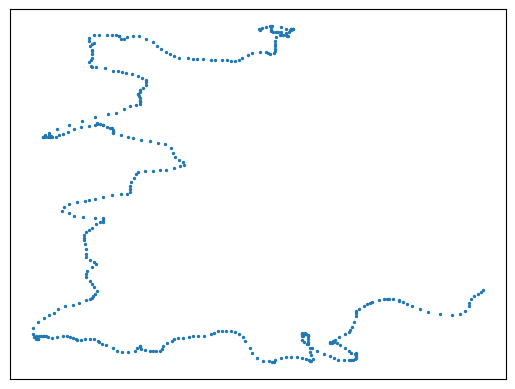

In [5]:
fig, ax = plt.subplots()


ax.scatter(position[100:500, 0], position[100:500, 1], s = 2.0)

ax.set_xticks([])
ax.set_yticks([])

plt.show()

In [6]:
cell_1_spikes = cellspikes[1][0]

In [7]:
cell_1_spikes[:100]

array([6881326.35, 6881342.  , 6881412.9 , 6881443.75, 6881520.35,
       6881626.45, 6881628.2 , 6881667.  , 6881673.35, 6881741.05,
       6881795.2 , 6881903.4 , 6881931.35, 6881949.7 , 6881955.2 ,
       6881968.75, 6881977.45, 6882056.8 , 6882083.7 , 6882092.1 ,
       6882116.75, 6882169.  , 6882175.25, 6882225.  , 6882232.1 ,
       6882239.7 , 6882265.75, 6882274.  , 6882314.5 , 6882323.35,
       6882337.35, 6882384.55, 6882521.3 , 6882534.7 , 6882650.2 ,
       6882663.  , 6882767.  , 6882767.9 , 6882832.6 , 6882910.15,
       6882914.05, 6883004.65, 6883050.75, 6883053.3 , 6883175.8 ,
       6883279.3 , 6883319.75, 6883370.25, 6883378.15, 6883390.5 ,
       6883519.8 , 6883601.05, 6883607.9 , 6883821.15, 6883855.1 ,
       6883922.45, 6884061.05, 6884097.45, 6884129.  , 6884177.4 ,
       6884187.05, 6884212.25, 6884241.55, 6884325.15, 6884350.4 ,
       6884386.65, 6884406.7 , 6884453.6 , 6884518.95, 6884526.3 ,
       6884552.65, 6884644.95, 6884745.9 , 6884747.9 , 6884898

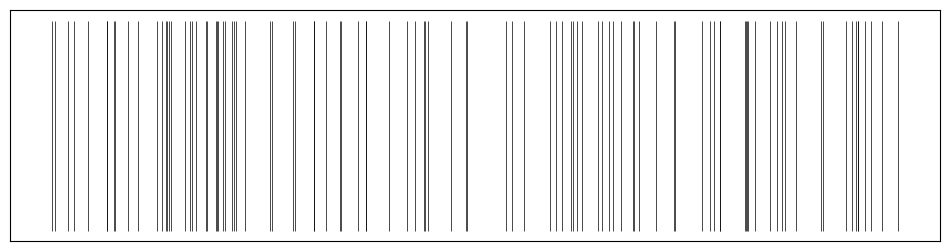

In [8]:
fig, ax = plt.subplots(figsize = (12, 3))

ax.vlines(cell_1_spikes[:100], 0, 1, linewidth=.5, color = 'black')
ax.set_yticks([])
ax.set_xticks([])



plt.savefig('spiketrain.png')

In [9]:
cell_1_spikes

array([6881326.35, 6881342.  , 6881412.9 , ..., 9069916.95, 9070040.  ,
       9070182.1 ])

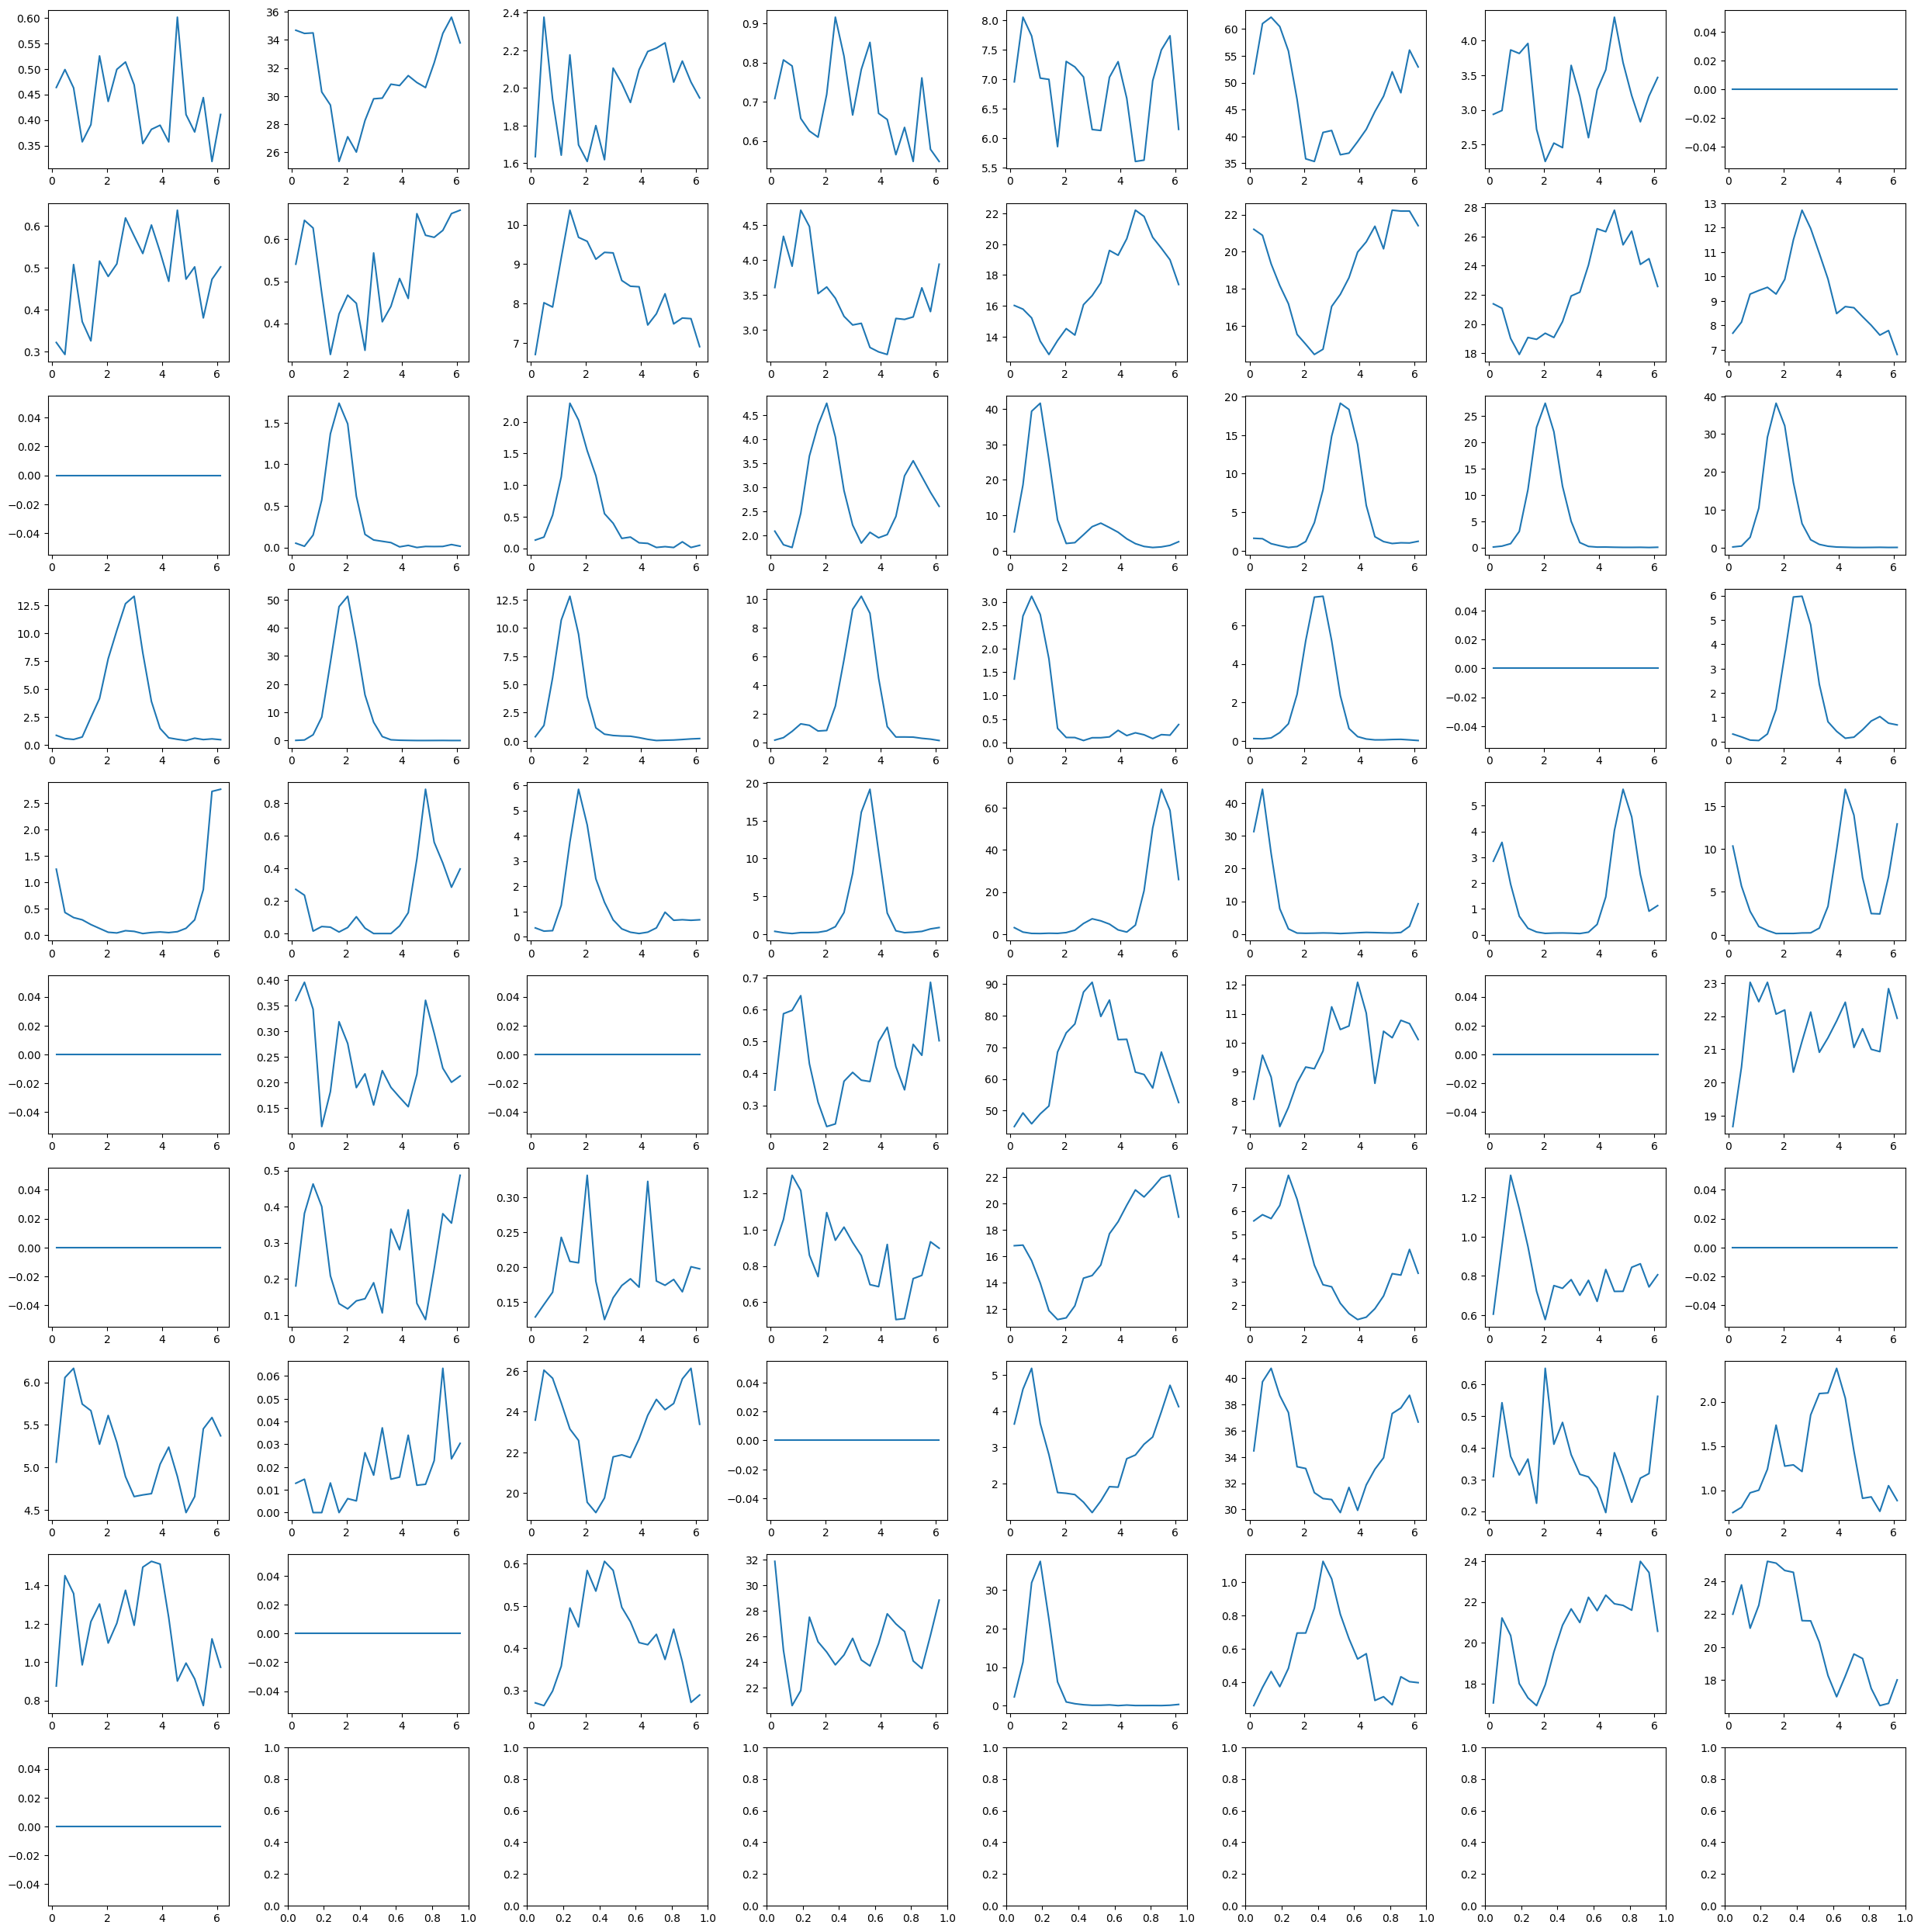

In [10]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

tuning_curve_dict = {}

num_rows = 10
num_cols = 8

fig, ax = plt.subplots(nrows = num_rows, ncols = num_cols, figsize = (25, 25))


for cell_number in range(73):

    row_index, col_index = np.divmod(cell_number, num_cols)


    spike_times = cellspikes[cell_number]/1000
    hd_times = trackingtimes/1000
    hd_angles = headangle

    # Parameters
    n_bins = 20  # e.g., 6° bins

    # Step 1: Interpolate head direction at spike times
    hd_interp_func = interp1d(hd_times, hd_angles, kind='linear', bounds_error=False, fill_value='extrapolate')
    spike_angles = hd_interp_func(spike_times) % (2 * np.pi)  # wrap to [0, 2π]

    # Step 2: Compute occupancy (time spent in each direction bin)
    # Estimate time spent in each direction by binning hd_angles
    occupancy_hist, bin_edges = np.histogram(hd_angles, bins=n_bins, range=(0, 2*np.pi))
    # Convert count to time by multiplying by sampling interval
    # Assuming uniform sampling
    dt = np.median(np.diff(hd_times))
    occupancy_time = occupancy_hist * dt

    # Step 3: Compute spike count histogram
    spike_hist, _ = np.histogram(spike_angles, bins=bin_edges)

    # Step 4: Normalize to get firing rate
    with np.errstate(divide='ignore', invalid='ignore'):
        firing_rate = spike_hist / occupancy_time
        firing_rate[np.isnan(firing_rate)] = 0.0  # optional cleanup

    # Step 5: Plot tuning curve
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2



    ax[row_index, col_index].plot(bin_centers, firing_rate)
    


    tuning_curve = np.zeros((20, 2))
    tuning_curve[:, 0] = np.linspace(0, 2*np.pi - (1/20)*2*np.pi, 20)
    tuning_curve[:, 1] = firing_rate
    tuning_curve_dict[cell_number] = tuning_curve





plt.tight_layout()
plt.show()

In [11]:
for _, tuning_curve in tuning_curve_dict.items():
    max = np.max(tuning_curve[:, 1])
    if max != 0:
        tuning_curve[:, 1] = 50 * tuning_curve[:, 1] / max
    tuning_curve[:, 0] = tuning_curve[:, 0]/(2*np.pi)

In [12]:
# Arguments: 
# position: a number in [0,1) representing a position on the circle S^1 = R/Z
# tuning_curve_array: tuning curve on a circle, represented as R/Z. First column should be x positions (in [0,1)) and second column should be firing rates
# Function: computes firing rate by linearly interpolating between data points that describe the tuning curve
def calculate_firing_rate_from_tuning_curve(position, tuning_curve_array):
    if position < 0 or position >= 1:
        raise Exception('Invalid position.')
    num_positions = tuning_curve_array.shape[0]

    # Handle edge case where we run into 0~1 identification
    if position >= tuning_curve_array[num_positions - 1, 0] or position <= tuning_curve_array[0, 0]:
        x_1 = tuning_curve_array[num_positions - 1, 0]
        y_1 = tuning_curve_array[num_positions - 1, 1]
        x_2 = tuning_curve_array[0, 0] + 1
        y_2 = tuning_curve_array[0, 1]
        slope = (y_2 - y_1)/(x_2 - x_1)
        if position <= tuning_curve_array[0, 0]:
            rate = slope*((position + 1) - x_1) + y_1
            return rate
        else:
            rate = slope*((position) - x_1) + y_1
            return rate
    
    # Otherwise, just linearly interpolate
    else:
        index = np.searchsorted(tuning_curve_array[:, 0], position) - 1
        x_1 = tuning_curve_array[index, 0]
        y_1 = tuning_curve_array[index, 1]
        x_2 = tuning_curve_array[index + 1, 0]
        y_2 = tuning_curve_array[index + 1, 1]
        slope = (y_2 - y_1)/(x_2 - x_1)
        rate = slope*(position - x_1) + y_1
        return rate
    

# Arguments 
# path_on_circle: a path on a circle = R/Z, i.e., a  np.array of shape (num_steps,) consisting of values in [0,1)
# tuning_curves: a dictionary of num_neurons (neuron_index, tuning_curve)-pairs
# Output
# a (num_neurons x num_steps) matrix where row i is neuron i's response to the path_on_circle as a time series 
def calculate_response_matrix_given_walk_on_circle_and_tuning_curves(path_on_circle, tuning_curves):
    num_steps = len(path_on_circle)
    num_neurons = len(tuning_curves.keys())
    response_matrix = np.zeros((num_neurons, num_steps))
    for neuron_index in range(num_neurons):
        tuning_curve = tuning_curves[neuron_index]
        for step_index in range(num_steps):
            response_matrix[neuron_index, step_index] = calculate_firing_rate_from_tuning_curve(path_on_circle[step_index], tuning_curve)
    return response_matrix

# Adds normal random noise to a matrix with fixed integer seed for reproducability
def add_normal_random_noise(matrix, integer_seed, nonzero_entry_std_dev_factor, min_std_dev):
    np.random.seed(integer_seed)

    noisy_matrix = matrix.copy()

    noisy_matrix = np.maximum(0, np.random.normal(noisy_matrix, np.maximum(nonzero_entry_std_dev_factor*noisy_matrix, min_std_dev)))

    return noisy_matrix


In [13]:
tuning_curve_dict[0]

array([[ 0.        , 38.5629532 ],
       [ 0.05      , 41.47897898],
       [ 0.1       , 38.49828047],
       [ 0.15      , 29.71836138],
       [ 0.2       , 32.51083695],
       [ 0.25      , 43.69747899],
       [ 0.3       , 36.29285939],
       [ 0.35      , 41.50757077],
       [ 0.4       , 42.70552561],
       [ 0.45      , 39.        ],
       [ 0.5       , 29.4374702 ],
       [ 0.55      , 31.74901371],
       [ 0.6       , 32.42218675],
       [ 0.65      , 29.70620239],
       [ 0.7       , 50.        ],
       [ 0.75      , 34.15605096],
       [ 0.8       , 31.32301402],
       [ 0.85      , 36.91983122],
       [ 0.9       , 26.52660218],
       [ 0.95      , 34.17056075]])

In [14]:
circular_positions = np.linspace(1, 7, 50000) % 1
    

In [15]:
response_matrix = calculate_response_matrix_given_walk_on_circle_and_tuning_curves(circular_positions, tuning_curve_dict)
response_matrix = add_normal_random_noise(response_matrix, 2, .05, 2.5)

In [16]:
response_matrix

array([[37.52105858, 38.42928473, 33.23646016, ..., 34.94069727,
        39.16510387, 39.60538269],
       [50.37109199, 51.8299224 , 42.61429094, ..., 55.2036039 ,
        48.1526981 , 46.44531094],
       [33.69832837, 31.14015855, 32.07291912, ..., 33.52196472,
        32.26106603, 33.85347113],
       ...,
       [35.4465751 , 34.74302444, 36.55134053, ..., 36.51672363,
        35.31004141, 36.13109243],
       [44.39231892, 41.27944478, 45.06072569, ..., 43.16070202,
        42.36350068, 40.74244698],
       [ 0.        ,  2.05827535,  1.1636489 , ...,  6.96204339,
         0.15084235,  2.22859199]])

In [17]:
correlation = np.corrcoef(response_matrix)

In [18]:
correlation = 1 + correlation
correlation = correlation/np.max(correlation)
correlation = 1 - correlation

<Axes: >

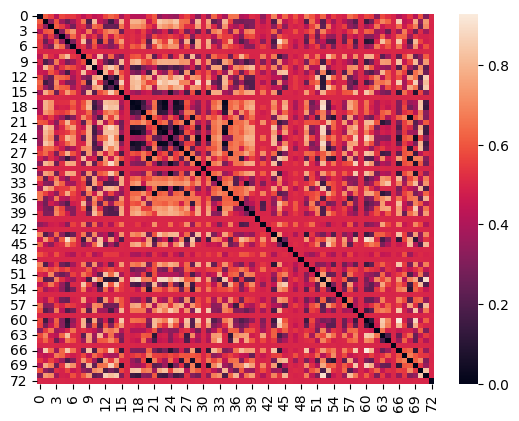

In [19]:
sns.heatmap(correlation)

In [20]:
result = ripser(correlation, distance_matrix = True)

In [21]:
dim_1_barcode = result['dgms'][1]

In [22]:

def plot_n_longest_bars(array, n):
    # Sort the array based on the width of the bars (x_end - x_start)
    sorted_array = sorted(array, key=lambda x: x[1] - x[0], reverse=True)
    
    # Take the first n rows from the sorted array
    n_longest_bars = sorted_array[:n]
    
    # Create a figure and axis
    fig, ax = plt.subplots()
    
    # Plot each of the n longest bars
    for i in range(len(n_longest_bars)):
        x_start, x_end = n_longest_bars[i]
        width = x_end - x_start
        ax.hlines(i, x_start, x_end, linewidth=5, color='black')
    
    # Set plot limits and labels
    ax.set_xlim(0, 1)
    ax.set_ylim(-1, len(n_longest_bars))
    ax.set_xlabel('')
    ax.set_title('')
    
    # Hide y-axis ticks and labels
    ax.set_yticks([])
    ax.set_yticklabels([])
    
    # Hide x-axis ticks and labels
    ax.set_xticks([])
    ax.set_xticklabels([])
    
    # Show grid lines
    ax.grid(True, axis='x', linestyle='--', linewidth=0.5, alpha=0.5, color='gray')
    
    plt.xticks(np.arange(0, 1.1, 0.1))
    
    # Show the plot
    plt.show()


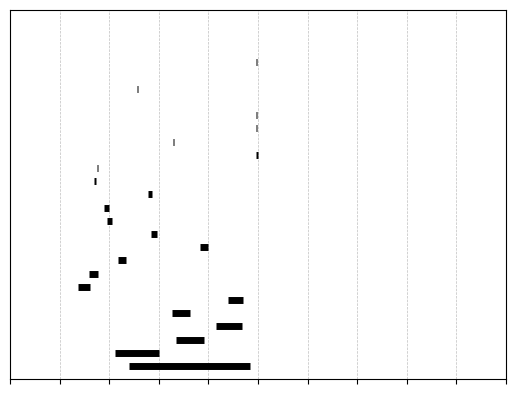

In [23]:
plot_n_longest_bars(dim_1_barcode, 100)

Text(0.5, 0, 'Orientation (degrees)')

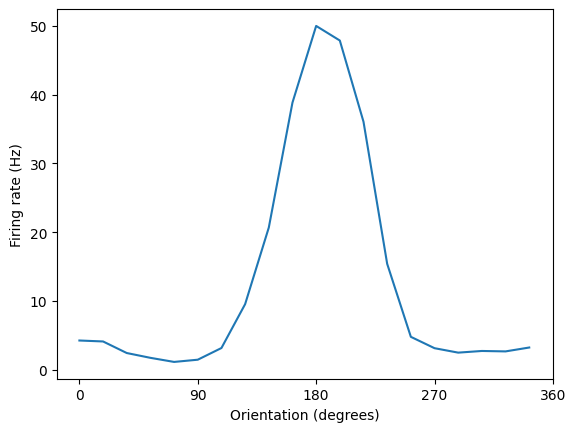

In [32]:
cell_number_for_tuning_curve = 21


fig, ax = plt.subplots()

ax.plot(tuning_curve_dict[cell_number_for_tuning_curve][:, 0], tuning_curve_dict[cell_number_for_tuning_curve][:, 1])

ax.set_xticks([0, .25, .5, .75, 1])
ax.set_xticklabels(['0', '90', '180', '270', '360'])
ax.set_ylabel('Firing rate (Hz)')
ax.set_xlabel('Orientation (degrees)')
